In [19]:
# Importar librerias
import pandas as pd
import numpy as np
import json
import os
import seaborn as sns
import matplotlib.pyplot as plt

from src.catching import attempt_catch
from src.pokemon import PokemonFactory, StatusEffect

np.random.seed(0)

factory = PokemonFactory("pokemon.json")
with open("pokemon.json") as f:
    pokemones_names = list(json.load(f).keys())


# Acerca de las pokebolas

**1.A**
Ejecutando la función 100 veces, para cada Pokemon en condiciones ideales (HP:100 %, LVL 100) ¿Cuál es la probabilidad de captura promedio para cada pokebola?

In [20]:
N = 100
HP = 1.
LVL = 1.
balls = ["pokeball", "ultraball", "heavyball", "fastball"]
results = []

for pokemon_name in pokemones_names:
    for ball in balls:
        pokemon = factory.create(pokemon_name, HP, StatusEffect.NONE, LVL)
        for _ in range(100):
            caught, capture_rate = attempt_catch(pokemon, ball)
            results.append({
                "pokemon": pokemon_name,
                "ball": ball,
                "caught": caught,
                "capture_rate": capture_rate
            })

results = pd.DataFrame(results)
print("Probabilidad de captura promedio por tipo de pokeball")
print(results.groupby("ball").mean()["capture_rate"])

Probabilidad de captura promedio por tipo de pokeball
ball
fastball     0.13472
heavyball    0.10194
pokeball     0.09722
ultraball    0.19438
Name: capture_rate, dtype: float64


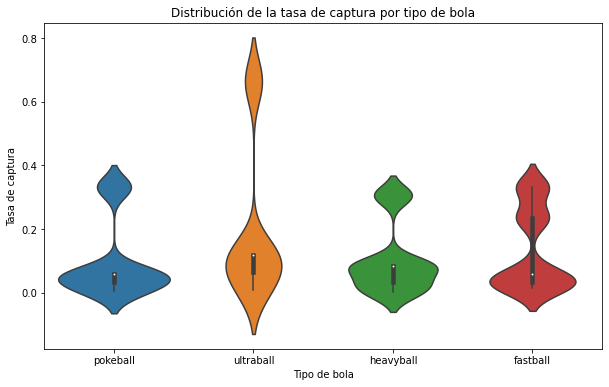

In [21]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='ball', y='capture_rate', data=results)
plt.title('Distribución de la tasa de captura por tipo de bola')
plt.xlabel('Tipo de bola')
plt.ylabel('Tasa de captura')
plt.show()

**1.B**
¿Es cierto que algunas pokebolas son más o menos efectivas dependiendo de propiedades intrínsecas de cada Pokemon? Justiﬁcar.
Sugerencia: Comparar efectividad (success/total attemps) como proporción de la efectividad de la Pokebola básica para cada Pokemon

**Repuesta:**

 Si, eso es cierto en especial para el pokemon caterpie. Siendo la ultraball la mejor alternativa para ese caso.

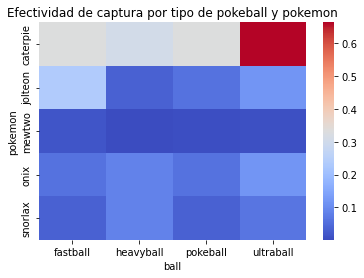

ball      fastball  heavyball  pokeball  ultraball
pokemon                                           
caterpie    0.3321     0.3061    0.3321     0.6642
jolteon     0.2345     0.0327    0.0587     0.1173
mewtwo      0.0157     0.0014    0.0040     0.0079
onix        0.0587     0.0848    0.0587     0.1173
snorlax     0.0326     0.0847    0.0326     0.0652


In [22]:
pivot_results = results.pivot_table(
    index="pokemon",
    columns="ball",
    values="capture_rate",
    aggfunc="mean"
)
sns.heatmap(pivot_results, cmap="coolwarm")
plt.title("Efectividad de captura por tipo de pokeball y pokemon")
plt.show()
print(pivot_results)

# Acerca del estado del pokemon

In [23]:
def simular(pokemon, ball, n=100, noise=0.1):
    """Ejecuta la función de captura de pokemones n veces.
    
    Args:
        pokemon (Pokemon): instancia de pokemon
        ball (str): tipo de bola
        n (int, optional): cantidad de ejecuciones de la función.
        noise (float, optional): ruido en la tasa de captura.

    Returns:
        list: lista de diccionarios con los resultados de la simulación
    """
    results = []
    for _ in range(n):
        caught, capture_rate = attempt_catch(pokemon, ball, noise)
        results.append({
            "pokemon": pokemon.name,
            "ball": ball,
            "caught": caught,
            "hp": pokemon.current_hp,
            "max_hp": pokemon.max_hp,
            "lv": pokemon.level,
            "capture_rate": capture_rate,
            "status_effect": pokemon.status_effect.name
        })
    return results

**2.A**
¿Las condiciones de salud tienen algún efecto sobre la efectividad de la captura? Si es así, ¿Cual es más o menos efectiva?

**Respuesta:**

Sí, las condiciones de salud afectan la efectividad de la captura.

La condición menos efectiva es que no tenga ninguna condición de salud (NONE), mientras que la condición más efectiva es que el pokemon se encuentre durmiendo (SLEEP).


In [24]:
from itertools import product

HP = 1.
LVL = 1.
effects = [
    StatusEffect.NONE,
    StatusEffect.BURN,
    StatusEffect.PARALYSIS,
    StatusEffect.POISON,
    StatusEffect.SLEEP
]
results = []
for pokemon, ball, effect in product(pokemones_names, balls, effects):
    pokemon = factory.create(pokemon, HP, effect, LVL)
    results.extend(simular(pokemon, ball))

results = pd.DataFrame(results)

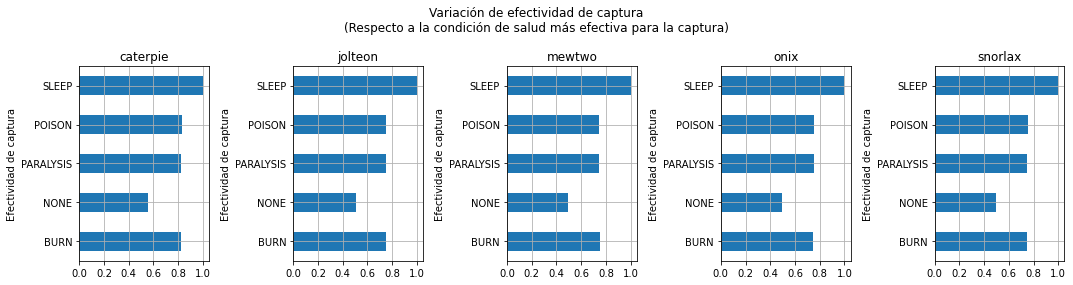

In [25]:
grouped_results = results\
    .groupby(["pokemon", "status_effect"])\
    .mean()["capture_rate"]

fig, axes = plt.subplots(
    1, len(grouped_results.index.levels[0]),
    figsize=(15, 4),
)

for i, pokemon in enumerate(grouped_results.index.levels[0]):
        efectividad = grouped_results.loc[pokemon]
        efectividad /= efectividad.max()
        efectividad.plot.barh(
            ax=axes[i],
            title=pokemon,
            grid=True,
            xlabel="Efectividad de captura",
            xticks=np.arange(0, 1.1, 0.2), 
        )
        
plt.suptitle(
    "Variación de efectividad de captura\n" + 
    "(Respecto a la condición de salud más efectiva para la captura)")
plt.tight_layout()
plt.show()

**2.B**
¿Cómo afectan los puntos de vida a la efectividad de la captura?

Sugerencia: Elegir uno o dos Pokémon y, manteniendo el resto de los parámetros constantes, calcular la probabilidad de captura para distintos % de HP.

**Respuesta:**

La efectividad de captura del pokemon cae linealmente en función del % de HP.

In [26]:
HP = 1.
EFFECT = StatusEffect.NONE
BALL = "pokeball"

hp_array = np.arange(0.0, 1.1, 0.1)
results = []
for pokemon, hp in product(pokemones_names, hp_array):
    pokemon = factory.create(pokemon, LVL, EFFECT, hp)
    results.extend(simular(pokemon, BALL))

results = pd.DataFrame(results)
results["percent_hp"] = results["hp"] / results["max_hp"]

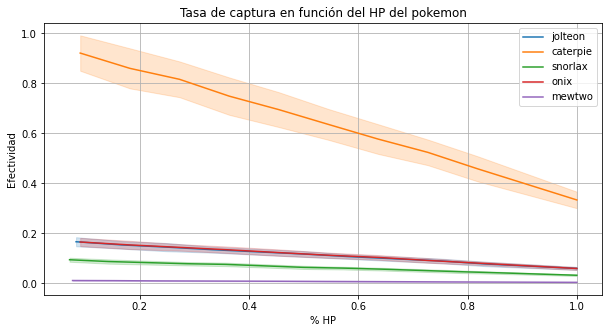

In [27]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=results, x='percent_hp', y='capture_rate', hue='pokemon', ci="sd")
plt.title('Tasa de captura en función del HP del pokemon')
plt.xlabel('% HP')
plt.ylabel('Efectividad')
plt.legend()
plt.grid()
plt.show()

**2.C**
¿Qué parámetros son los que más afectan la probabilidad de captura?

**Respuesta:**

El estado de salud afecta de igual manera a la probabilidad de captura.

Para cada pokemon en particular se observa que:

- Jolteon: Es más sensible al uso de las diferentes pokebolas
- Caterpie: Es más sensible al % de HP que posee
- Snorlax, Onix, y Mewtwo: No presentan gran sensibilidad pero dependen del % de HP y de la pokebola usada

In [28]:
hp_array = np.linspace(0.0, 1.0, 10, endpoint=True)
lvl_array = np.linspace(0.0, 1.0, 10, endpoint=True)
balls = ["pokeball", "ultraball", "heavyball", "fastball"]
effects = [StatusEffect.NONE, StatusEffect.BURN, StatusEffect.PARALYSIS, StatusEffect.POISON, StatusEffect.SLEEP]

results = []
for pokemon_name, hp, lvl, ball, effect in product(pokemones_names, hp_array, lvl_array, balls, effects):
    pokemon = factory.create(pokemon_name, lvl, effect, hp)
    results.extend(simular(pokemon, ball))

results = pd.DataFrame(results)
results["percent_hp"] = results["hp"] / results["max_hp"]
max_capture_rate = results.groupby("pokemon").max()["capture_rate"].to_dict()

results["normalized_capture_rate"] = results["capture_rate"] / results["pokemon"].replace(max_capture_rate)


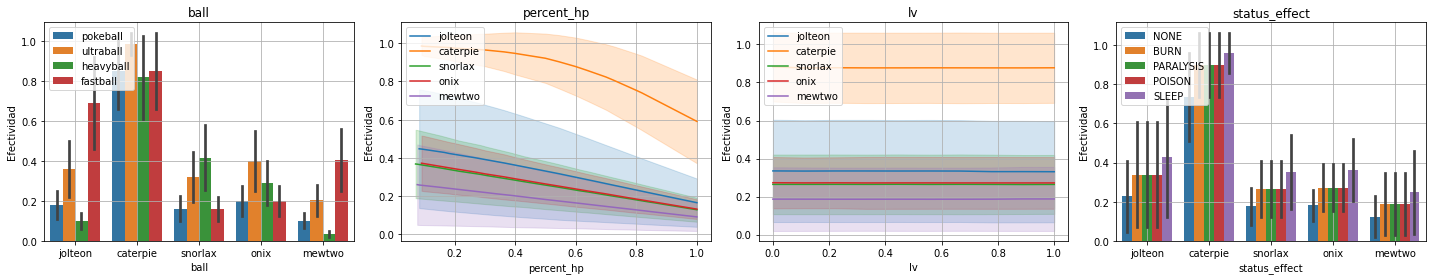

In [29]:
columnas = ["ball", "percent_hp", "lv", "status_effect"]
graficos = ["barplot", "lineplot", "lineplot", "barplot"]

fig, axes = plt.subplots(
    1, len(columnas),
    figsize=(20, 4),
)

for i, col in enumerate(columnas):
    if graficos[i] == "barplot":
        sns.barplot(data=results, x='pokemon', y='normalized_capture_rate',
                    hue=col, ci="sd", ax=axes[i])
    else:
        sns.lineplot(data=results, x=col, y='normalized_capture_rate',
                     hue='pokemon', ci="sd", ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Efectividad')
    axes[i].grid()
    axes[i].legend(loc='upper left')

plt.tight_layout()
plt.show()

**2.D**
Teniendo en cuenta uno o dos pokemones distintos: ¿Qué combinación de condiciones (propiedades mutables) y pokebola conviene utilizar para capturarlos?

**Respuesta:**

Viendo los graficos es conveniente para todos los pokemones que el % de HP sea lo más bajo posible y que dicho pokemon este dormido (SLEEP).

La pokebola a utilizar para cada pokemon es:



In [30]:
max_per_ball = results\
    .groupby(["pokemon", "ball"])\
    .mean()["capture_rate"]\
    .unstack()
for pokemon, row in max_per_ball.iterrows():
    ball = row.index[row.argmax()]
    print("Para {}:\n\tes conveniente utilizar {}.".format(pokemon, ball))

Para caterpie:
	es conveniente utilizar ultraball.
Para jolteon:
	es conveniente utilizar fastball.
Para mewtwo:
	es conveniente utilizar fastball.
Para onix:
	es conveniente utilizar ultraball.
Para snorlax:
	es conveniente utilizar heavyball.


**2.E**
A partir del punto anterior, ¿sería efectiva otra combinación de parámetros teniendo en cuenta un nivel del pokemon más bajo (o más alto)?

**Respuesta:**

En terminos generales no, ya que el valor medio de la efectividad es indenpendiente del nivel de vida del pokemon.